In [11]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [12]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/bridge"  

font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

Fit=0.002, Map=1.0


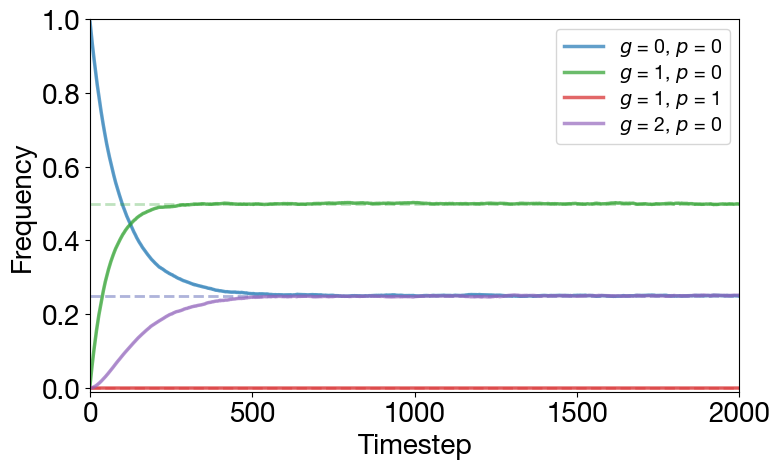

Fit=0.002, Map=0.95


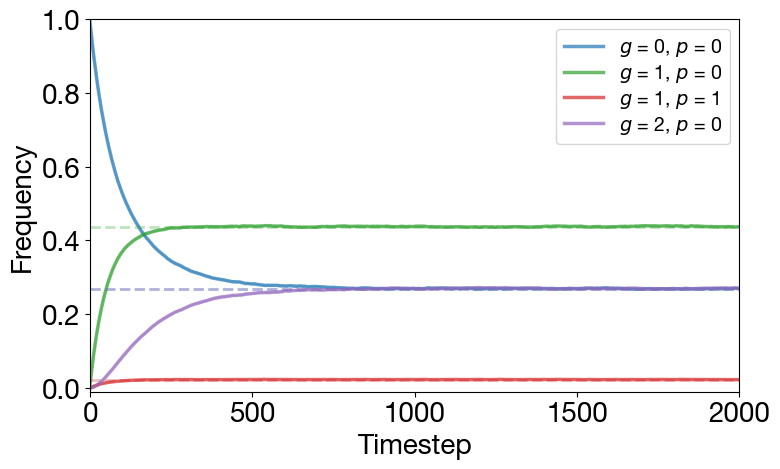

Fit=0.002, Map=0.9


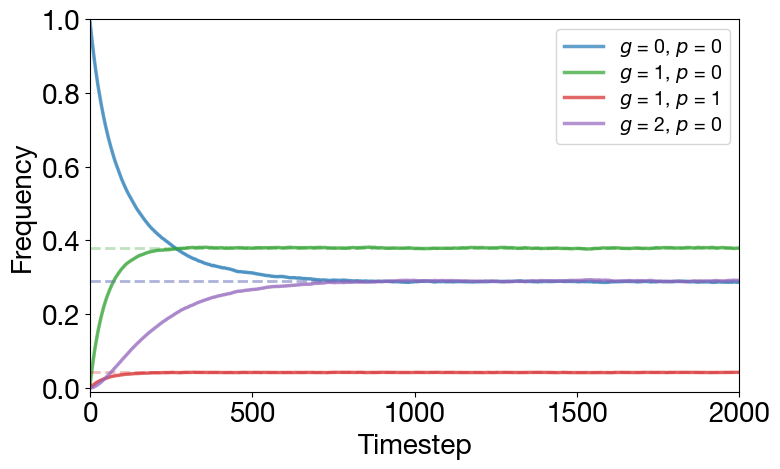

Fit=0.002, Map=0.85


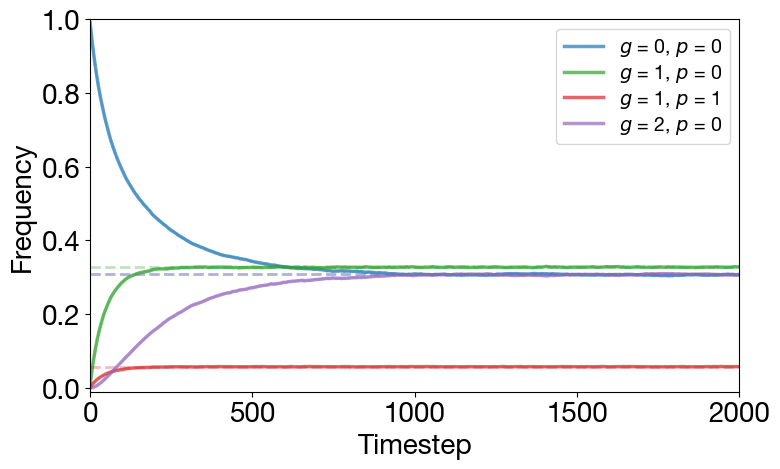

Fit=0.002, Map=0.8


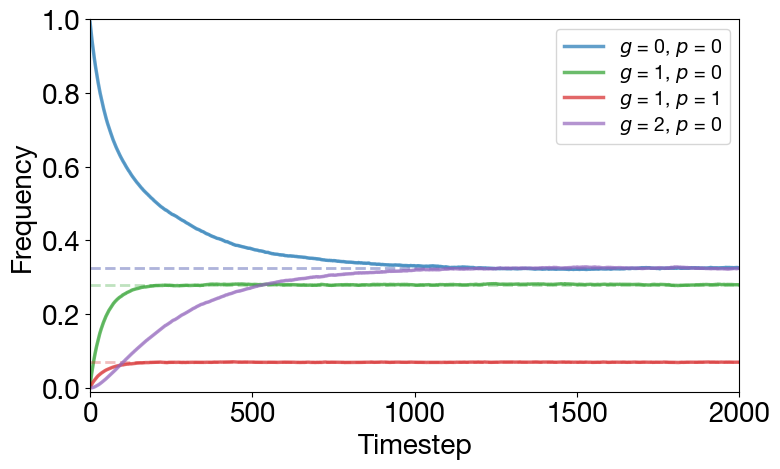

Fit=0.002, Map=0.75


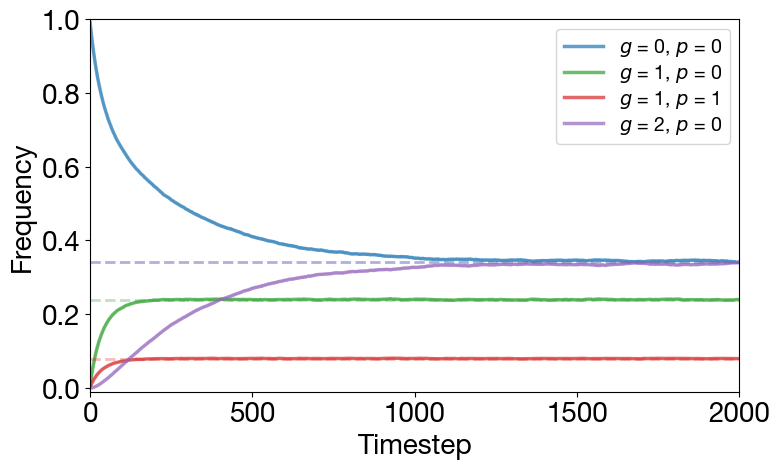

Fit=0.002, Map=0.7


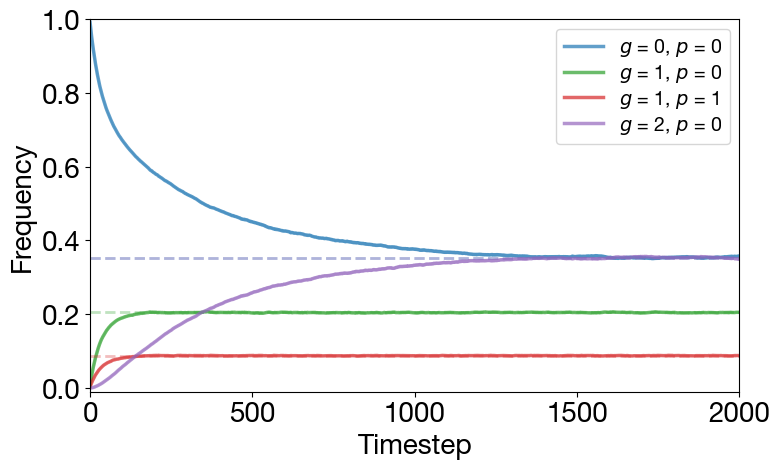

Fit=0.0002, Map=1.0


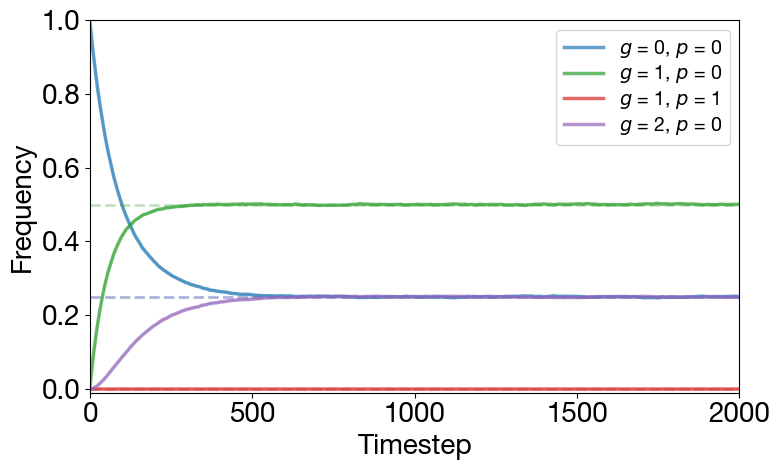

Fit=0.0002, Map=0.95


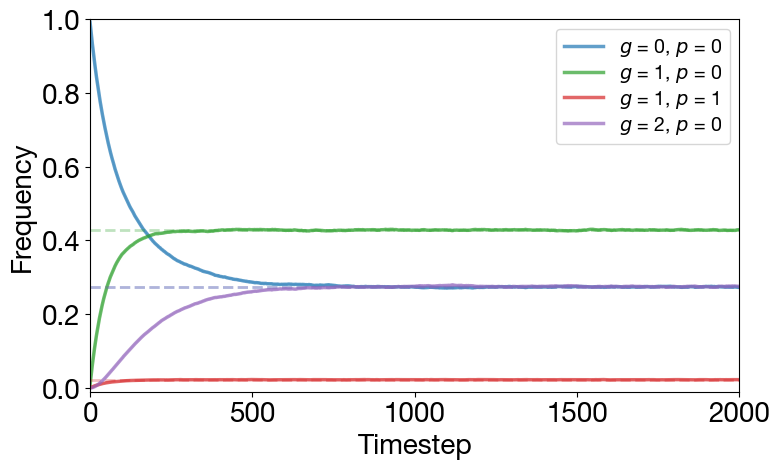

Fit=0.0002, Map=0.9


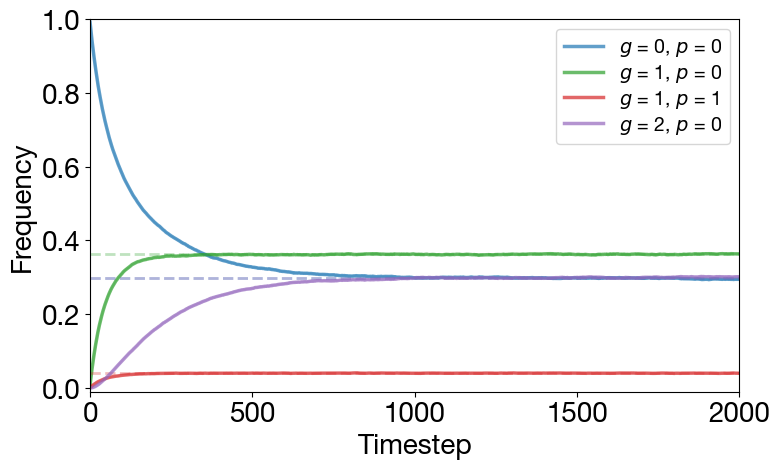

Fit=0.0002, Map=0.85


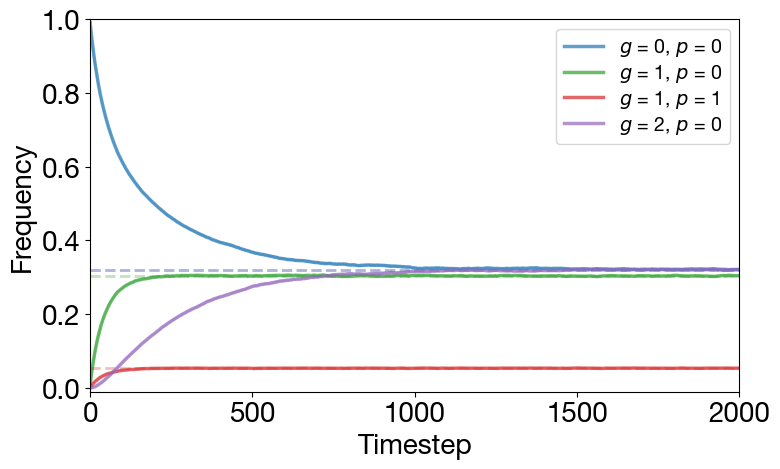

Fit=0.0002, Map=0.8


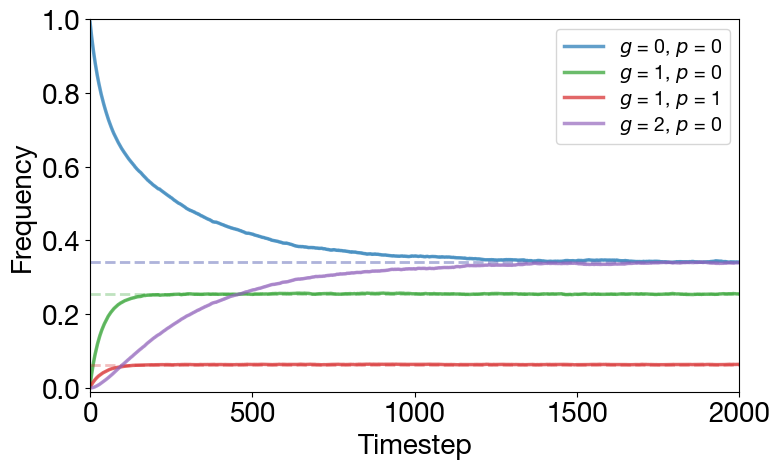

Fit=0.0002, Map=0.75


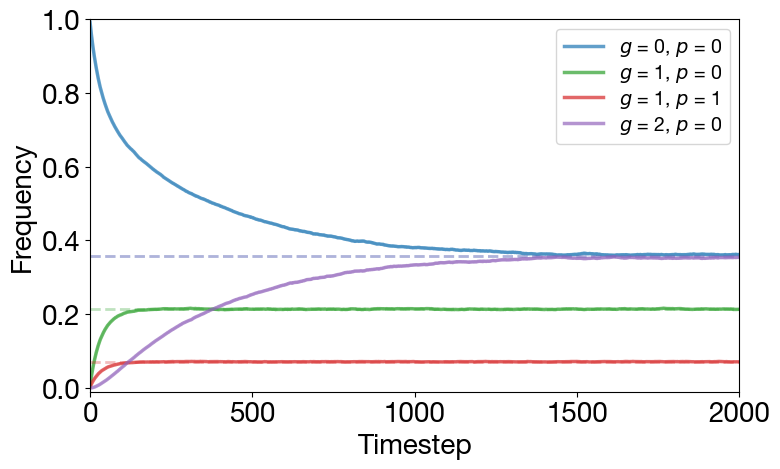

Fit=0.0002, Map=0.7


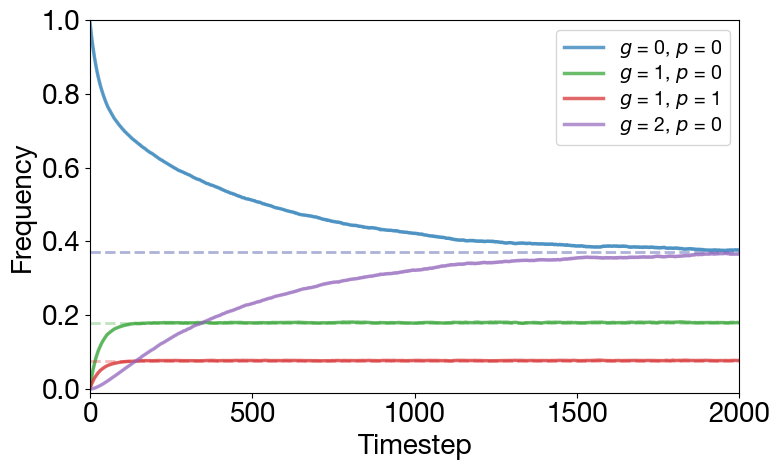

In [13]:
# -------------------------
# Settings
# -------------------------
fits = ["0.002", "0.0002"]         # fitness values 

# regex to parse filenames
pattern = re.compile(r"sim_data_map_(.*?)_fit_(.*?)_trial_(\d+)\.pkl")

# collect files
files = os.listdir(data_dir)

# organize files by (map, fit)
groups = {}
for fname in files:
    match = pattern.match(fname)
    if match:
        map_val, fit_val, trial = match.groups()
        key = (map_val, fit_val)
        groups.setdefault(key, []).append(os.path.join(data_dir, fname))

# -------------------------
# Compute averages and plot
# -------------------------
for fit in fits:
    map_vals = sorted(
        set(map_val for (map_val, f) in groups.keys() if f == fit),
        key=lambda x: float(x)
    )

    for map_val in map_vals:
        key = (map_val, fit)
        file_list = groups[key]

        trajectories = []

        # load all trials
        for fpath in file_list:
            with open(fpath, "rb") as f:
                data = pickle.load(f)
                # freq_timeseries shape: (Ng, Np, T)
                trajectories.append(data["freq_timeseries"])
                theoretical_vals = np.array(data['f_eq']).reshape(3,2) # same for all 


        trajectories = np.array(trajectories)  # (num_trials, Ng, Np, T)

        mean_traj = trajectories.mean(axis=0)   # (Ng, Np, T)
        sem_traj = trajectories.std(axis=0) / np.sqrt(len(trajectories))

        # -------------------------
        # Plot each (i,j)
        # -------------------------
        plt.figure(figsize=(8, 5))
        Ng, Np, T = mean_traj.shape
        timepoints = np.arange(T)

        # keep only these (i, j) pairs
        selected_pairs = [(0, 0), (1, 0), (1, 1), (2, 0)]

        for i in range(Ng):
            for j in range(Np):
                if (i, j) not in selected_pairs:
                    # still advance the color cycle to keep consistency
                    plt.plot([], [])  
                    continue

                line, = plt.plot(
                    timepoints,
                    mean_traj[i, j, :],
                    label=f'$g$ = {i}, $p$ = {j}', 
                    alpha=0.7, 
                    linewidth=2.5
                )
                plt.fill_between(
                    timepoints,
                    mean_traj[i, j, :] - sem_traj[i, j, :],
                    mean_traj[i, j, :] + sem_traj[i, j, :],
                    alpha=0.2,
                    color=line.get_color()
                )

                # theoretical horizontal line
                th = theoretical_vals[i, j]
                plt.axhline(
                    th, linestyle="--", linewidth=2,
                    alpha=0.3, color=plt.gca().lines[-1].get_color()  # match curve color
                )

        map_val = 1 - float(map_val)
        print(f"Fit={fit}, Map={map_val}")
        plt.xlabel("Timestep")
        plt.ylabel("Frequency")
        plt.legend(fontsize=14, loc="upper right", labelspacing=0.2)
        plt.tight_layout()
        plt.ylim(-0.01, 1)
        plt.xlim(-0.1, 2000)
        plt.show()